In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [11]:
all_data = []
for root, dirs, files in os.walk("/content/drive/MyDrive/Colab Notebooks/NLP_Marathon_DL/Data/spam_data"):
    for name in files:
        filename = os.path.join(root, name)
        is_spam = 0 if 'ham' in filename else 1
        # codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(filename, encoding='utf-8', errors='ignore') as f:
            for line in f.readlines():
                # 這個line的開頭為Subject:
                if line.startswith('Subject:'):
                    subject = re.sub(r'^Subject:', '', line).strip()
                    all_data.append([subject, is_spam])
all_data = np.array(all_data)

In [12]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [13]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
X = clean_content(X)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 2000)
X=cv.fit_transform(X).toarray()

In [16]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [17]:
np.unique(y_train)

array([0, 1], dtype=uint8)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
class LinearBNAC(nn.Module):
    def __init__(self,in_channels,out_channels,bias = True, dropout=0.3, is_output=False):
        super(LinearBNAC,self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels,out_channels, bias = bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels,out_channels,bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace = True),
                nn.Dropout(dropout)
            )
    def forward(self,x):
        out= self.linear(x)
        return out

In [20]:
class Model(nn.Module):
    def __init__(self, input_dimension,output_classes=1):
        super(Model,self).__init__()
        self.layer1 = LinearBNAC(input_dimension,16)
        self.layer2 = LinearBNAC(16,32)
        self.output = LinearBNAC(32,output_classes,is_output = True)
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x

In [21]:
model = Model(input_dimension = 2000 ,output_classes = 2).to(device)

In [22]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 2000])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])


In [23]:
batch_size = 4
input_features = 2000
dummy_input = torch.randn(batch_size,input_features).to(device)

In [24]:
dummy_output = model(dummy_input)
print(dummy_output)

tensor([[ 0.5248,  0.3767],
        [ 0.0155, -0.9396],
        [ 0.2833, -0.6844],
        [ 0.3711, -0.1468]], device='cuda:0', grad_fn=<AddmmBackward>)


In [25]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [26]:
criterion = CrossEntropyLoss()

In [27]:
import torch.optim as optim

In [28]:
optimizer = optim.Adam(params = model.parameters(),lr = 1e-3)

In [29]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [30]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

In [31]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):   
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()

    for batch in range(len(x_train) // batch_size):
        x = x_train[batch * batch_size:(batch + 1) * batch_size,:]
        y = y_train[batch * batch_size:(batch + 1) * batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print(f'epoch : {epoch}')
        print(f'目前 train loss : {np.mean(loss_keeper):.2f}')
        print(f'目前 test loss : {loss_test:.2f}')
        print(f'目前 test accuracy : {test_accuracy:.2f}')

epoch : 0
目前 train loss : 0.41
目前 test loss : 0.34
目前 test accuracy : 0.86
epoch : 2
目前 train loss : 0.29
目前 test loss : 0.26
目前 test accuracy : 0.91
epoch : 4
目前 train loss : 0.24
目前 test loss : 0.25
目前 test accuracy : 0.90
epoch : 6
目前 train loss : 0.22
目前 test loss : 0.22
目前 test accuracy : 0.91
epoch : 8
目前 train loss : 0.20
目前 test loss : 0.21
目前 test accuracy : 0.91
epoch : 10
目前 train loss : 0.19
目前 test loss : 0.22
目前 test accuracy : 0.91
epoch : 12
目前 train loss : 0.18
目前 test loss : 0.22
目前 test accuracy : 0.90
epoch : 14
目前 train loss : 0.16
目前 test loss : 0.24
目前 test accuracy : 0.90
epoch : 16
目前 train loss : 0.16
目前 test loss : 0.22
目前 test accuracy : 0.90
epoch : 18
目前 train loss : 0.15
目前 test loss : 0.24
目前 test accuracy : 0.89
epoch : 20
目前 train loss : 0.17
目前 test loss : 0.25
目前 test accuracy : 0.89
epoch : 22
目前 train loss : 0.15
目前 test loss : 0.26
目前 test accuracy : 0.88
epoch : 24
目前 train loss : 0.14
目前 test loss : 0.26
目前 test accuracy : 0.87
epoch : 26
目前 tra

In [32]:
print(classification_report(prediction, y_test_numpy))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       558
           1       0.73      0.57      0.64       127

    accuracy                           0.88       685
   macro avg       0.82      0.76      0.78       685
weighted avg       0.87      0.88      0.88       685



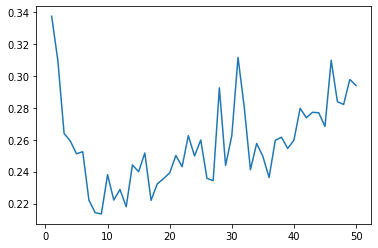

In [33]:
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_) + 1), test_loss_)
plt.show()

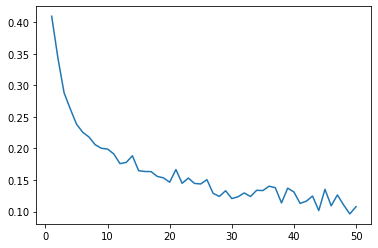

In [34]:
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_) + 1), train_loss_)
plt.show()

In [35]:
saving_location = './model_save.pth'   # './' 代表目前所屬路徑
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': loss_test
           }, f=saving_location)

In [37]:
model = Model(input_dimension=2000, output_classes=2).to(device)

## 載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content = cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
